In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import re
import string
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
    
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, Conv1D, Dense, Dropout, Attention, Bidirectional
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import nltk
nltk.download('stopwords')
log_dir = "logs/"  # Especifique o diretório onde os logs serão armazenados
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gyova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
df = pd.read_csv('../data/dataset1.csv')
df = df.drop(columns=['index'])
df.isnull().any()

label                False
preprocessed_news    False
dtype: bool

In [13]:
stop_words = set(stopwords.words('portuguese'))

def remover_stop_words(news):
    palavras = news.split()
    palavras_sem_stop = [palavra for palavra in palavras if palavra.lower() not in stop_words]
    return ' '.join(palavras_sem_stop)

def review_cleaning(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df["preprocessed_news"] = df["preprocessed_news"].apply(remover_stop_words)
df['label'] = df.apply(lambda row: 0 if row.label == 'fake' else 1, axis=1)
X = df.drop(['label'], axis = 1)
Y = df['label']


In [14]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify=Y)
X_train = X_train['preprocessed_news'].apply(lambda x: x.lower())
X_test = X_test['preprocessed_news'].apply(lambda x: x.lower())

In [15]:
#variaveis dos modelos
maxlen=256
num_words = 8000
batch_size = 128 
epochs = 20 
validation_fraction = 0.2
output_dim = 64



early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [16]:
train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>',num_words=num_words)
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index
train_sequences = train_tokenizer.texts_to_sequences(X_train)

text_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>',num_words=num_words)
text_tokenizer.fit_on_texts(X_test.values)
text_word_index = text_tokenizer.word_index
text_sequences = text_tokenizer.texts_to_sequences(X_test)

vocab_length = len(train_word_index) + 1

train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(text_sequences, maxlen=maxlen)

train_padded_seqeunces = train_padded_seqeunces[:, :, tf.newaxis]
test_padded_seqeunces = test_padded_seqeunces[:, :, tf.newaxis]

x_train_padded_seqeunces = train_padded_seqeunces[:, :, tf.newaxis]
x_test_padded_seqeunces = test_padded_seqeunces[:, :, tf.newaxis]

vectorizer = CountVectorizer(max_features=num_words)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train).toarray()

vectorizer = CountVectorizer(max_features=num_words)
vectorizer.fit(X_test)
X_test = vectorizer.transform(X_test).toarray()

In [22]:

with open('../models/MLPClassifierWithGridSearchCVV2.pkl', 'rb') as arquivo:
    clf = pickle.load(arquivo)

    
modelLSTM = load_model('../models/modelLSTMV2.keras')
modelHAN = load_model('../models/modelHAN.keras')


#### MLP

Inicio do Teste
Matriz de confusão


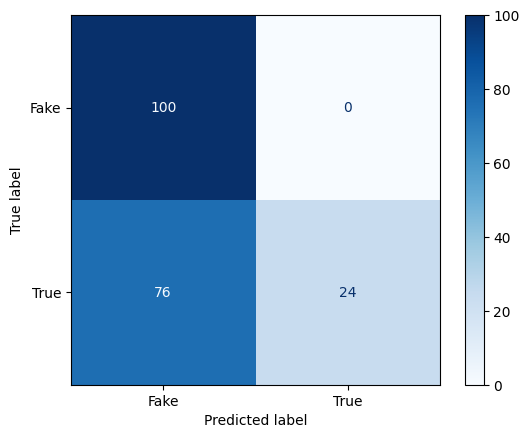

Fim do Teste


In [24]:

print("Inicio do Teste")
y_test_pred = clf.predict(X_test)
y_test_pred = (y_test_pred > 0.70)
mlp_acc = round(accuracy_score(y_test, y_test_pred), 2)

cm = confusion_matrix(y_test, y_test_pred)

print("=" * 20)
print("Matriz de confusão")
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=['Fake','True'])
disp.plot(cmap='Blues', values_format='.0f')
#plt.savefig('../matriz/confusion_matrix_MLP.png')
plt.show()
print("Fim do Teste")




In [ ]:
print("Número total de iterações:", len(mlp_hist.cv_results_['params']))


In [ ]:
print("=" * 20)
print("Matriz de confusão")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True'])
disp.plot(values_format='.0f')
plt.savefig('../matriz/confusion_matrix_MLP.png')
plt.show()
print("Fim do Teste")

#### RNN (LSTM bidirecionais)

In [ ]:
print("=" * 20)
print("Modelo RNN (LSTM bidirecionais)")

modelLSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, output_dim, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
modelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print('Summary do modelo RNN (LSTM bidirecionais) ')
modelLSTM.summary()
print()
# Função para contar iterações
class BatchCounter(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.batch_count = 0

    def on_batch_end(self, batch, logs=None):
        self.batch_count += 1
batch_counter_callback = BatchCounter()


print("Inciando do treinamento")
historyLSTM = modelLSTM.fit(train_padded_seqeunces, y_train, epochs=epochs, validation_split=0.3, callbacks=[early_stopping,tensorboard_callback,batch_counter_callback])
print("Fim do treinamento")

LSTM_train = round(historyLSTM.history['accuracy'][-1] * 100, 2)

print("Salvando modelo")
modelLSTM.save('../models/modelLSTMV2.keras', save_format='tf')


In [ ]:
print(f'Total de iterações: {batch_counter_callback.batch_count}')

print("Inicio do Teste")

y_test_pred = modelLSTM.predict(test_padded_seqeunces)
y_test_pred = (y_test_pred > 0.70)
lstm_acc = round(accuracy_score(y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

print("Matriz de confusão")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falsa','Verdadeira'], )
disp.plot(values_format='.0f')
plt.savefig('../matriz/confusion_matrix_LSTM.png')
plt.show()

print("Fim dos testes")

print("=" * 30)




In [ ]:
plt.plot(historyLSTM.history['loss'])
plt.title('Model loss progress during training')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.legend(['Training loss'])
plt.savefig('../graficos/loss_lstmV2.png')

In [ ]:
plt.plot(historyLSTM.history['accuracy'])
plt.title('Model accuracy progress during training')
plt.xlabel('Epoch')
plt.ylabel('Training accuracy')
plt.legend(['Training accuracy'])
plt.savefig('../graficos/accuracy_lstmV2.png')

In [ ]:
plot_model(modelLSTM, to_file='../summery/lstm.png', show_shapes=True, show_layer_names=True)

#### RNN (HAN)

In [ ]:
print("=" * 20)
print("Modelo RNN (HAN)")


def word_attention(x):
    return Attention()([x, x])

def sentence_attention(x):
    return Attention()([x, x])

document_input = Input(shape=(maxlen,))
word_embedding = Embedding(vocab_length, output_dim, input_length=maxlen)(document_input)
word_lstm = Bidirectional(LSTM(50, return_sequences=True))(word_embedding)
word_attention = word_attention(word_lstm)
sentence_lstm = Bidirectional(LSTM(20, return_sequences=True))(word_attention)
sentence_attention = sentence_attention(sentence_lstm)
doc_lstm = Bidirectional(LSTM(10))(sentence_attention)
dense_layer = Dense(5, activation='relu')(doc_lstm)
dropout_layer = tf.keras.layers.Dropout(0.5)(dense_layer)
output = Dense(1, activation='sigmoid')(dropout_layer)

model_han = tf.keras.Model(inputs=document_input, outputs=output)
model_han.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


print('Summary do modelo RNN (LSTM bidirecionais) ')
model_han.summary()
print()

print("Inciando do treinamento")
historyHAN = model_han.fit(train_padded_seqeunces, y_train, epochs=epochs, validation_split=0.2, callbacks=[early_stopping,tensorboard_callback])
print("Fim do treinamento")

HAN_train = round(historyHAN.history['accuracy'][-1] * 100, 2)

print("Salvando modelo")

#model_han.save('../models/modelHAN.keras', save_format='tf')



In [ ]:

print("Inicio do Teste")
y_test_pred = model_han.predict(test_padded_seqeunces)
y_test_pred = (y_test_pred > 0.70)
han_acc = round(accuracy_score(y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

print("Matriz de confusão")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falsa','Verdadeira'], )
disp.plot(values_format='.0f')
plt.savefig('../matriz/confusion_matrix_HAN.png')
plt.show()

print("Fim dos testes")


In [ ]:

print("=" * 30)

plt.plot(historyHAN.history['loss'])
plt.title('Model loss progress during training')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.legend(['Training loss'])
plt.savefig('../graficos/loss_han.png')



In [ ]:

plt.plot(historyHAN.history['accuracy'])
plt.title('Model accuracy progress during training')
plt.xlabel('Epoch')
plt.ylabel('Training accuracy')
plt.legend(['Training accuracy'])
plt.savefig('../graficos/accuracy_han.png')



In [ ]:
plot_model(model_han, to_file='../summery/han.png', show_shapes=True, show_layer_names=True)

## resultado

In [32]:

with open('../models/MLPClassifierWithGridSearchCVV2.pkl', 'rb') as arquivo:
    mlpG = pickle.load(arquivo)

    
modelLSTM = load_model('../models/modelLSTMV2.keras')
modelHAN = load_model('../models/modelHAN.keras')





print("Inicio do Teste ")
y_test_pred = mlpG.predict(X_test)
y_test_pred = (y_test_pred > 0.70)
han_acc = round(accuracy_score(y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(y_test, y_test_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

print("Matriz de confusão")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falsa','Verdadeira'], )
disp.plot(values_format='.0f')
#plt.savefig('../matriz/confusion_matrix_HAN%.png')
plt.show()

print("Fim dos testes")




Inicio do Teste 


ValueError: could not convert string to float: 'victor chaves detona rede globo desrespeitosa profana jornalismo nao mostra coisa cantor victor dupla sertaneja victor leo falou poucas boas sobre rede globo atraves redes sociais acusado agredir fisicamente esposa fevereiro deste ano cantor disse globo colocou geladeira jamais pedi sair programa alegaram precisava preservado escreveu victor explicou indiciado vias fato nao crime tudo sera esclarecido rede globo tambem editou partes programa ja gravado tirou literalmente victor cenas inconformado cantor usou instagram desabafar sobre fato'

In [ ]:
mlpG_train =  round(mlp_hist.best_score_ * 100, 0)
mlp_acc =  round(mlp_hist.best_estimator_.score(X_test, y_test) * 100, 0)
LSTM_train = round(historyLSTM.history['accuracy'][-1] * 100, 0)
lstm_acc = round(accuracy_score(y_test, y_test_pred) * 100, 0)
HAN_train = round(historyHAN.history['accuracy'][-1] * 100, 0)
han_acc = round(accuracy_score(y_test, y_test_pred) * 100, 0)


In [ ]:
model = pd.DataFrame({
    'Model': [
        'MLP',
        'RNN LSTM(BI)',
        'HAN'
    ],
    'Train Accuracy Score': [
        
        mlpG_train ,LSTM_train,HAN_train
    ],
    'Test Accuracy': [
        
        mlp_acc ,lstm_acc,han_acc
    ]
})

In [ ]:
Train = model.sort_values('Test Accuracy',ascending=False)
Train